# MNIST FASHION DATASET

#### Name: Ryan Ueda Teo Shao Ming
#### Admin No: 2122924
#### S/N: 06
#### Class: DAAA/FT/2B/05

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras 
import math
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D
from keras.utils import plot_model
from keras.datasets import mnist
import tensorflow as tf
from keras.utils import to_categorical
from keras.preprocessing import image
from keras.utils import load_img, img_to_array 
from keras.utils import image_utils
from sklearn.model_selection import train_test_split
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras import initializers
from keras.callbacks import LearningRateScheduler
import keras.callbacks
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import Callback
from sklearn.model_selection import KFold
from numpy.random import seed
import keras_tuner as kt
import visualkeras
from sklearn.metrics import classification_report

tf.random.set_seed(42)

## Background Info On Dataset (Fashion MNIST)

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. 

Each example is a 28x28 grayscale image, associated with a label from 10 classes. Zalando intends Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. 

It shares the same image size and structure of training and testing splits.

## Exploratory Data Analysis

In [6]:
## check number of rows and columns in dataset
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

print("X Train -  rows:", X_train.shape[0]," columns:", X_train.shape[1])
print("X Test -  rows:", X_test.shape[0]," columns:", X_test.shape[1])

print("\nY Train -  rows:", y_train.shape[0])
print("Y Test -  rows:", y_test.shape[0])

X Train -  rows: 60000  columns: 28
X Test -  rows: 10000  columns: 28

Y Train -  rows: 60000
Y Test -  rows: 10000


<BarContainer object of 10 artists>

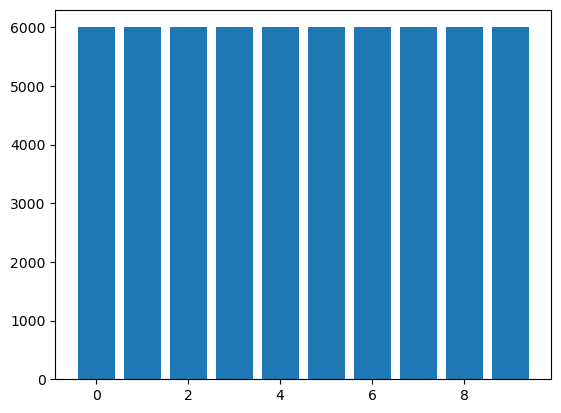

In [3]:
## check distribution of image samples per class
counts = np.array(np.unique(y_train, return_counts=True))
plt.bar(counts[0], counts[1])

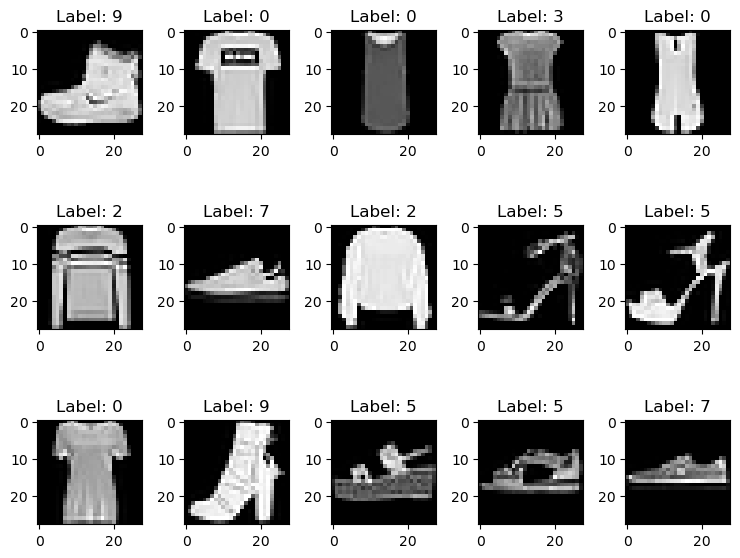

In [4]:
images = X_train[:15]
labels = y_train[:15]

## show a 3 X 5 grid sample of images
fig, axes = plt.subplots(3, 5, figsize=(1.5*5, 2*3))
for i in range(3*5):
    ax = axes[i//5, i%5]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
plt.tight_layout()
plt.show()

## Data Preprocessing

In [11]:
## read in MNIST data
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

## shuffle the data loaded to ensure there all data is random
indexes = np.arange(X_test.shape[0])
for _ in range(5): 
    indexes = np.random.permutation(indexes)  # shuffle 5 times
    X_test = X_test[indexes]
    y_test = y_test[indexes]
    
## split into validation and trains sets: 12000 validation, 48000 train
X_val = X_train[:12000]
y_val = y_train[:12000]
X_train = X_train[12000:]
y_train = y_train[12000:]

# reshape to fit into CNN model
X_train = X_train.reshape(48000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)
X_val = X_val.reshape(12000, 28, 28, 1)

## encode target variables
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
y_val = to_categorical(y_val, 10)

## normalization (also allows data to train faster)
X_train = X_train.astype('float32') / 255
X_val = X_val.astype('float32') / 255
X_test = X_test.astype('float32') / 255
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')
y_val = y_val.astype('float32')

In [12]:
## check new shapes of train, test and val data
print('X_train Shape: ' + str(X_train.shape))
print('y_train Shape: ' + str(y_train.shape))

print('\nX_test Shape: ' + str(X_test.shape))
print('y_test Shape: ' + str(y_test.shape))

print('\nX_val Shape: ' + str(X_val.shape))
print('y_val Shape: ' + str(y_val.shape))

X_train Shape: (48000, 28, 28, 1)
y_train Shape: (48000, 10)

X_test Shape: (10000, 28, 28, 1)
y_test Shape: (10000, 10)

X_val Shape: (12000, 28, 28, 1)
y_val Shape: (12000, 10)


## Model Architecture: Baseline Model

Here we define a model consisting of 2 hidden layers, 2 fully connected layers and an output layer. It is compiled with the adam optimizer and categorical crossentropy as its loss function. This will be used as our baseline model for further benchmarking.

In [14]:
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 flatten (Flatten)           (None, 73728)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               9437312   
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 10)                650       
                                                                 
Total params: 9,520,714
Trainable params: 9,520,714
No

In [16]:
## store metrics of each epoch in history

reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.0001, patience=3, verbose=1, min_lr=0.00001)
reduceLRAcc = ReduceLROnPlateau(monitor='val_accuracy', factor=0.0001, patience=2, verbose=1, min_lr=0.00001)
history = model.fit(X_train, y_train, batch_size=64, epochs=60, verbose=1,
                    workers=-1, use_multiprocessing=True, callbacks=[reduceLR, reduceLRAcc],
                    validation_data=(X_val, y_val))

## MODEL IS OVERFITTING

Epoch 1/60
750/750 [==============================] - 10s 8ms/step - loss: 0.4103 - accuracy: 0.8521 - val_loss: 0.2897 - val_accuracy: 0.8967 - lr: 0.0010
Epoch 2/60
750/750 [==============================] - 6s 7ms/step - loss: 0.2467 - accuracy: 0.9087 - val_loss: 0.2424 - val_accuracy: 0.9106 - lr: 0.0010
Epoch 3/60
750/750 [==============================] - 6s 7ms/step - loss: 0.1801 - accuracy: 0.9337 - val_loss: 0.2611 - val_accuracy: 0.9073 - lr: 0.0010
Epoch 4/60
750/750 [==============================] - 6s 7ms/step - loss: 0.1277 - accuracy: 0.9524 - val_loss: 0.2572 - val_accuracy: 0.9136 - lr: 0.0010
Epoch 5/60
744/750 [============================>.] - ETA: 0s - loss: 0.0859 - accuracy: 0.9688
Epoch 5: ReduceLROnPlateau reducing learning rate to 1e-05.
750/750 [==============================] - 5s 7ms/step - loss: 0.0858 - accuracy: 0.9688 - val_loss: 0.3037 - val_accuracy: 0.9145 - lr: 1.0000e-05
Epoch 6/60
750/750 [==============================] - 6s 7ms/step - loss: 0

We can see that the model did not perform very well, which is well within our expectations for the baseline model.

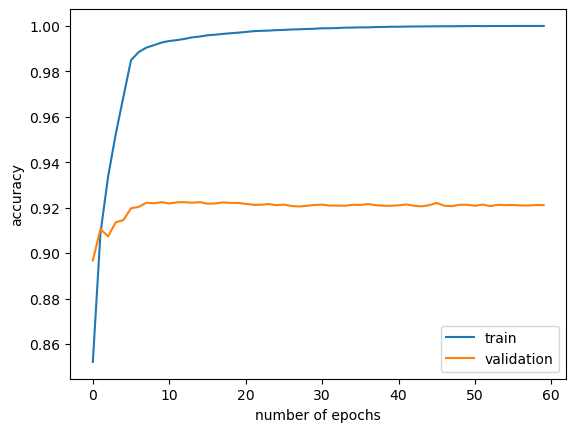

In [17]:
## plot validation accuracy vs train accuracy
modelAcc = history.history['accuracy']
valAcc = history.history['val_accuracy']

plt.figure()
plt.xlabel('number of epochs')
plt.ylabel('accuracy')
plt.plot(modelAcc, label='train')
plt.plot(valAcc, label='validation')
plt.legend(loc='lower right')
plt.show()


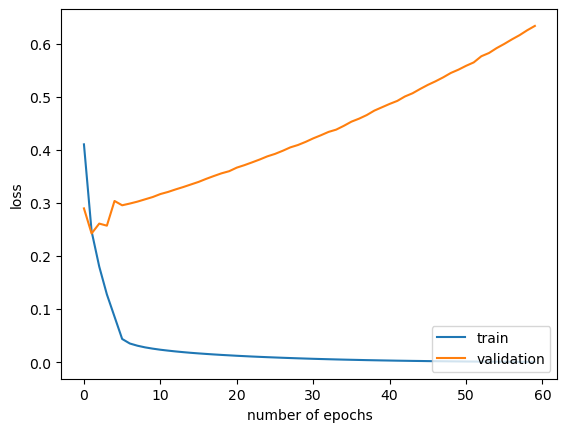

In [18]:
## plot validation loss vs train loss
modelLoss = history.history['loss']
valLoss = history.history['val_loss']

plt.figure()
plt.xlabel('number of epochs')
plt.ylabel('loss')
plt.plot(modelLoss, label='train')
plt.plot(valLoss, label='validation')
plt.legend(loc='lower right')
plt.show()

## graph shows model is overfitting

From the graphs we can clearly see that the model is greatly overfitted.

## Image Data Generator

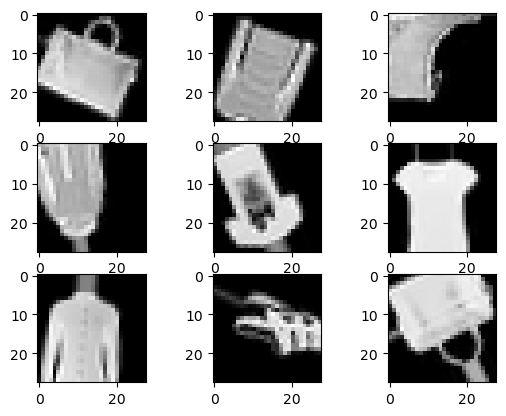

In [13]:
## image data gen
datagen = ImageDataGenerator(rescale=1./255, rotation_range=30, 
                             width_shift_range=0.2, height_shift_range=0.2,
                             horizontal_flip=True, vertical_flip=True)

## fit X_train 
datagen.fit(X_train)

## generate 10000 images and show 9 samples
for X_train_aug, y_train_aug in datagen.flow(X_train, y_train, batch_size=10000):
    ## 3 X 3 grid of images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_train_aug[i].reshape(28, 28), cmap=plt.get_cmap('gray'))

    ## show samples
    plt.show()
    break;

In [14]:
## concatenate images (X_train_aug, y_train_aug) generated to X_train, y_train
X_train = np.vstack((X_train, X_train_aug))
y_train = np.concatenate((y_train, y_train_aug))

print('X_train Shape: ' + str(X_train.shape))
print('y_train Shape: ' + str(y_train.shape))

X_train Shape: (58000, 28, 28, 1)
y_train Shape: (58000, 10)


## Model Architechture: Model 2

In [3]:
## model with 2 hidden layers + 2 dense layers + output
l2 = regularizers.L2(0.05)
heUni = initializers.HeUniform(seed=24)
model = Sequential()


model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, padding='same', input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, kernel_regularizer=l2))
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, kernel_regularizer=l2))

model.add(Dense(10, activation='softmax'))


adam = Adam(learning_rate=0.005)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

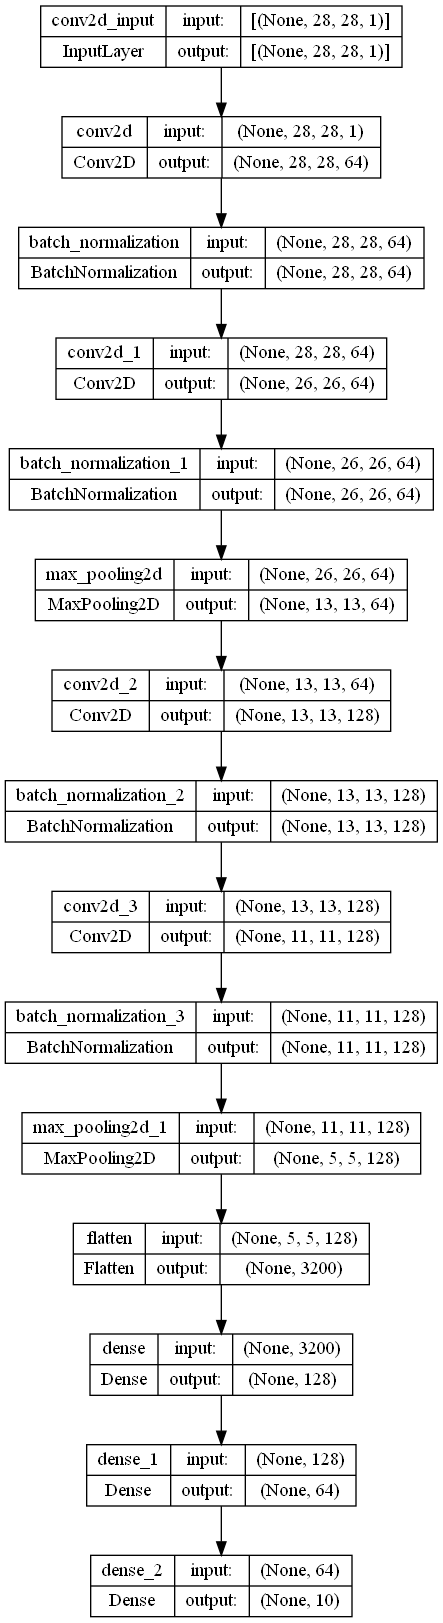

In [4]:
plot_model(model, show_shapes=True, show_layer_names=True)

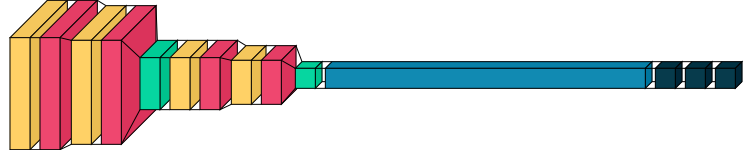

In [6]:
visualkeras.layered_view(model)

In [61]:
## store metrics of each epoch in history

reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.0001, patience=8, verbose=1, min_lr=0.00001)
reduceLRAcc = ReduceLROnPlateau(monitor='val_accuracy', factor=0.0001, patience=8, verbose=1, min_lr=0.00001)
EarlyStop = EarlyStopping(monitor='val_accuracy', patience=5)

history = model.fit(X_train, y_train, batch_size=64, epochs=45, verbose=1,
                    workers=-1, use_multiprocessing=True, callbacks=[reduceLR, reduceLRAcc],
                    validation_data=(X_val, y_val))

Epoch 1/45
907/907 [==============================] - 10s 10ms/step - loss: 1.7086 - accuracy: 0.7005 - val_loss: 0.8629 - val_accuracy: 0.7968 - lr: 0.0050
Epoch 2/45
907/907 [==============================] - 9s 10ms/step - loss: 0.8763 - accuracy: 0.7792 - val_loss: 0.5916 - val_accuracy: 0.8742 - lr: 0.0050
Epoch 3/45
907/907 [==============================] - 9s 9ms/step - loss: 0.7636 - accuracy: 0.8082 - val_loss: 0.5888 - val_accuracy: 0.8673 - lr: 0.0050
Epoch 4/45
907/907 [==============================] - 9s 10ms/step - loss: 0.7085 - accuracy: 0.8199 - val_loss: 0.5562 - val_accuracy: 0.8902 - lr: 0.0050
Epoch 5/45
907/907 [==============================] - 9s 10ms/step - loss: 0.6586 - accuracy: 0.8337 - val_loss: 0.5818 - val_accuracy: 0.8587 - lr: 0.0050
Epoch 6/45
907/907 [==============================] - 9s 9ms/step - loss: 0.6398 - accuracy: 0.8391 - val_loss: 0.4690 - val_accuracy: 0.8988 - lr: 0.0050
Epoch 7/45
907/907 [==============================] - 9s 9ms/step

In [62]:
## evaluate the model
score = model.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy: ' + str(score[1]))
print('Test Loss: ' + str(score[0]))

313/313 [==============================] - 1s 4ms/step - loss: 0.2938 - accuracy: 0.9218
Test Accuracy: 0.9218000173568726
Test Loss: 0.29384535551071167


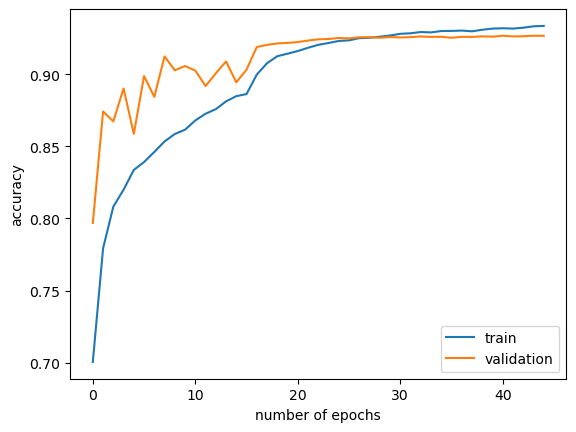

In [63]:
## plot validation accuracy vs train accuracy
modelAcc = history.history['accuracy']
valAcc = history.history['val_accuracy']

plt.figure()
plt.xlabel('number of epochs')
plt.ylabel('accuracy')
plt.plot(modelAcc, label='train')
plt.plot(valAcc, label='validation')
plt.legend(loc='lower right')
plt.show()

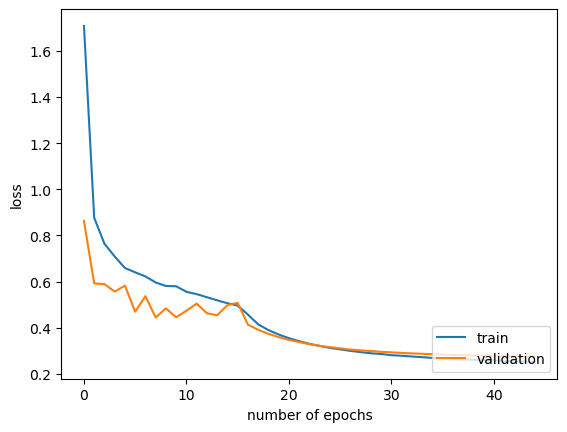

In [64]:
## plot validation loss vs train loss
modelLoss = history.history['loss']
valLoss = history.history['val_loss']

plt.figure()
plt.xlabel('number of epochs')
plt.ylabel('loss')
plt.plot(modelLoss, label='train')
plt.plot(valLoss, label='validation')
plt.legend(loc='lower right')
plt.show()

## Model Architecture: Model 3

We then experiment with a new model consisting of 3 hidden layers and 3 fully connected layers, while upping the number of neurons as well.

In [37]:
l2 = regularizers.L2(0.15)
heUni = initializers.HeUniform(seed=24)
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, padding='same', input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(256, activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, kernel_regularizer=l2))
model.add(Dropout(rate=0.2))
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, kernel_regularizer=l2))

model.add(Dense(10, activation='softmax'))


adam = Adam(learning_rate=0.002)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_14 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_17 (Conv2D)          (None, 26, 26, 32)        9248      
                                                                 
 batch_normalization_15 (Bat  (None, 26, 26, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                      

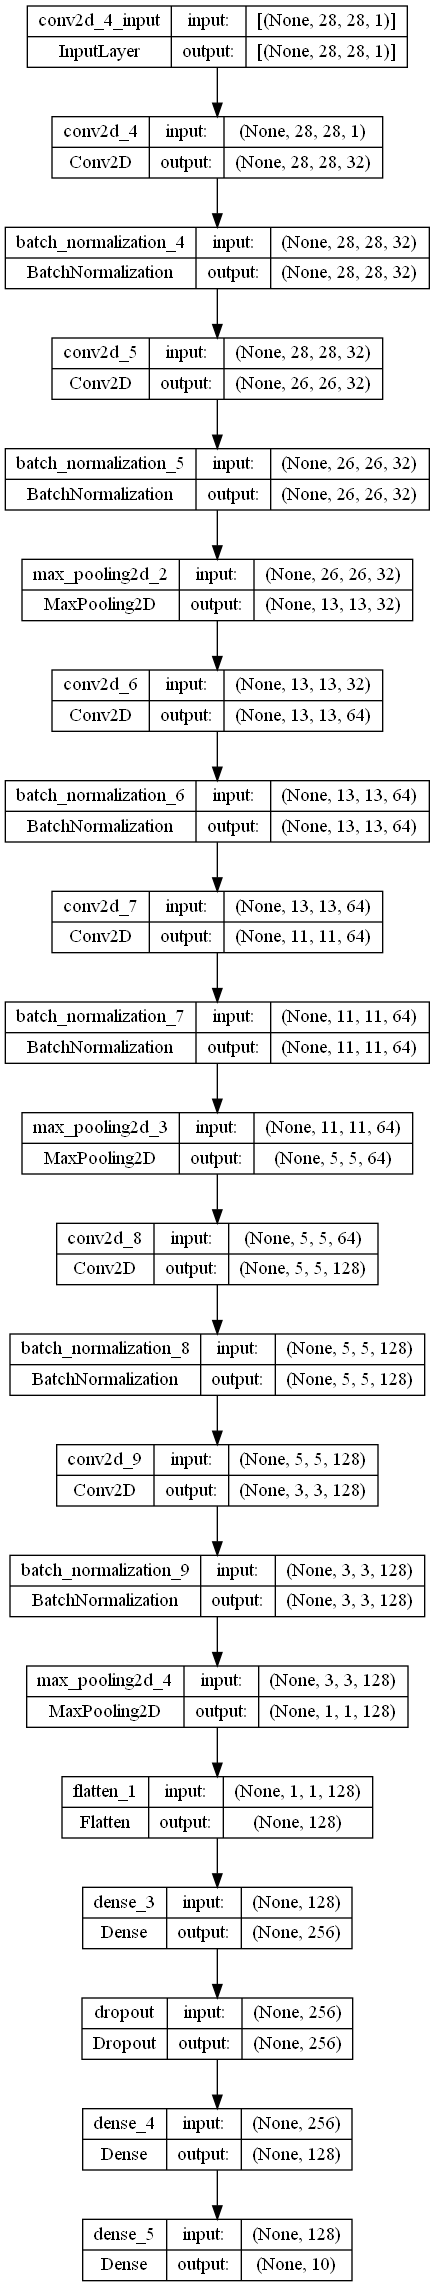

In [8]:
plot_model(model, show_shapes=True, show_layer_names=True)

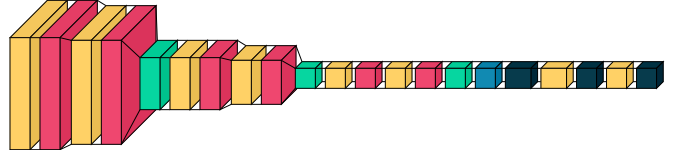

In [13]:
visualkeras.layered_view(model)

In [38]:
## store metrics of each epoch in history
earlyStop = EarlyStopping(monitor='val_accuracy', patience=8)
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.005, patience=3, verbose=1, min_lr=0.00001)
reduceLRAcc = ReduceLROnPlateau(monitor='val_accuracy', factor=0.005, patience=3, verbose=1, min_lr=0.00001)

history = model.fit(X_train, y_train, batch_size=128, epochs=40, verbose=1,
                    workers=-1, use_multiprocessing=True, callbacks=[reduceLR, reduceLRAcc, earlyStop],
                    validation_data=(X_val, y_val))

Epoch 1/40
454/454 [==============================] - 6s 11ms/step - loss: 8.4178 - accuracy: 0.7283 - val_loss: 0.8599 - val_accuracy: 0.8051 - lr: 0.0020
Epoch 2/40
454/454 [==============================] - 5s 11ms/step - loss: 0.7199 - accuracy: 0.8171 - val_loss: 0.5025 - val_accuracy: 0.9008 - lr: 0.0020
Epoch 3/40
454/454 [==============================] - 5s 11ms/step - loss: 0.6221 - accuracy: 0.8436 - val_loss: 0.4291 - val_accuracy: 0.9098 - lr: 0.0020
Epoch 4/40
454/454 [==============================] - 5s 11ms/step - loss: 0.5560 - accuracy: 0.8627 - val_loss: 0.4097 - val_accuracy: 0.9114 - lr: 0.0020
Epoch 5/40
454/454 [==============================] - 5s 11ms/step - loss: 0.5138 - accuracy: 0.8774 - val_loss: 0.4147 - val_accuracy: 0.9084 - lr: 0.0020
Epoch 6/40
454/454 [==============================] - 5s 11ms/step - loss: 0.4623 - accuracy: 0.8893 - val_loss: 0.4143 - val_accuracy: 0.9097 - lr: 0.0020
Epoch 7/40
449/454 [============================>.] - ETA: 0s - 

## Model Evaluation

In [39]:
## evaluate the model
score = model.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy: ' + str(score[1]))
print('Test Loss: ' + str(score[0]))

313/313 [==============================] - 1s 4ms/step - loss: 0.3000 - accuracy: 0.9280
Test Accuracy: 0.9279999732971191
Test Loss: 0.29997408390045166


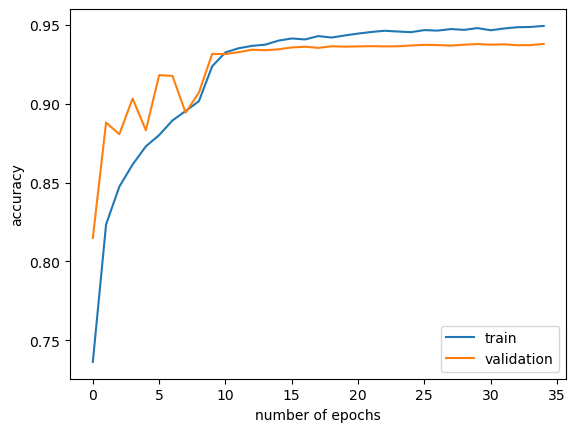

In [212]:
## plot validation accuracy vs train accuracy
modelAcc = history.history['accuracy']
valAcc = history.history['val_accuracy']

plt.figure()
plt.xlabel('number of epochs')
plt.ylabel('accuracy')
plt.plot(modelAcc, label='train')
plt.plot(valAcc, label='validation')
plt.legend(loc='lower right')
plt.show()

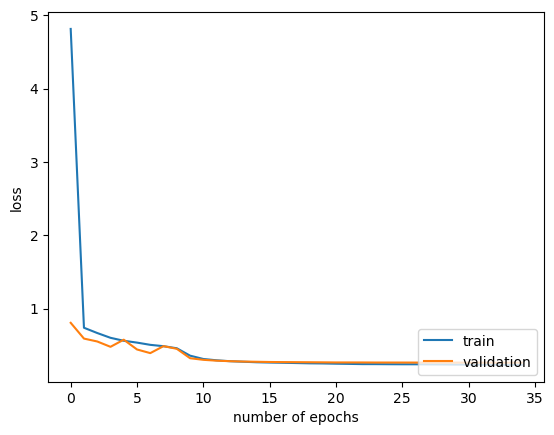

In [213]:
## plot validation loss vs train loss
modelLoss = history.history['loss']
valLoss = history.history['val_loss']

plt.figure()
plt.xlabel('number of epochs')
plt.ylabel('loss')
plt.plot(modelLoss, label='train')
plt.plot(valLoss, label='validation')
plt.legend(loc='lower right')
plt.show()

In [39]:
predict = model.predict(X_test)
predicted = np.argmax(predict, axis=1)
actual = np.argmax(y_test, axis=1)
print(classification_report(actual, predicted))

313/313 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.88      0.89      0.88      1000
           1       1.00      0.98      0.99      1000
           2       0.90      0.90      0.90      1000
           3       0.91      0.93      0.92      1000
           4       0.87      0.89      0.88      1000
           5       0.99      0.98      0.99      1000
           6       0.79      0.76      0.77      1000
           7       0.96      0.98      0.97      1000
           8       0.99      0.99      0.99      1000
           9       0.98      0.96      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



## Hyperparameter Tuning

In [9]:
def build_model(hp):
    
    model = Sequential()
    
    ## parameters to tune
    hp_act = hp.Choice('activation', values=['relu', 'leaky_relu', 'tanh'])
    hp_init = hp.Choice('bias_initializer', values=['HeUniform', 'HeNormal', 'GlorotUniform', 'GlorotNormal'])
    hp_dropRate = hp.Choice('rate', values=[0.2, 0.3, 0.4])
    hp_lr = hp.Choice('learning_rate', values=[0.001, 0.002, 0.003])
    hp_opt = hp.Choice('optimizer', values=['adam', 'sgd'])
    hp_reg = hp.Choice('kernel_regularizer', values=['l1', 'l2'])
    
    model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), activation=hp_act, kernel_initializer=hp_init, bias_initializer=hp_init, padding='same', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), activation=hp_act, kernel_initializer=hp_init, bias_initializer=hp_init))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation=hp_act, kernel_initializer=hp_init, bias_initializer=hp_init, padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation=hp_act, kernel_initializer=hp_init, bias_initializer=hp_init))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), activation=hp_act, kernel_initializer=hp_init, bias_initializer=hp_init, padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), activation=hp_act, kernel_initializer=hp_init, bias_initializer=hp_init))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(128, activation=hp_act, kernel_initializer=hp_init, bias_initializer=hp_init, kernel_regularizer=hp_reg))
    model.add(Dropout(rate=hp_dropRate))
    model.add(Dense(64, activation=hp_act, kernel_initializer=hp_init, bias_initializer=hp_init, kernel_regularizer=hp_reg))
    model.add(Dropout(rate=hp_dropRate))
    model.add(Dense(10, activation='softmax'))


    adam = Adam(learning_rate=hp_lr)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [23]:
tuner = kt.Hyperband(build_model, objective='val_accuracy', max_epochs=30, factor=3, directory='hypertune_3', project_name='test')
tuner.search(X_train, y_train, epochs=30, validation_data=(X_val, y_val), workers=-1)
best_hp=tuner.get_best_hyperparameters()[0]

INFO:tensorflow:Reloading Oracle from existing project hypertune_3\test\oracle.json
INFO:tensorflow:Reloading Tuner from hypertune_3\test\tuner0.json
INFO:tensorflow:Oracle triggered exit


In [24]:
tuner.results_summary()

Results summary
Results in hypertune_3\test
Showing 10 best trials
Trial summary
Hyperparameters:
activation: relu
bias_initializer: HeUniform
rate: 0.2
learning_rate: 0.001
optimizer: adam
kernel_regularizer: l2
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0048
Score: 0.9293749928474426
Trial summary
Hyperparameters:
activation: relu
bias_initializer: HeUniform
rate: 0.4
learning_rate: 0.003
optimizer: sgd
kernel_regularizer: l2
tuner/epochs: 30
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.9286249876022339
Trial summary
Hyperparameters:
activation: relu
bias_initializer: GlorotUniform
rate: 0.4
learning_rate: 0.001
optimizer: sgd
kernel_regularizer: l2
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0049
Score: 0.9283750057220459
Trial summary
Hyperparameters:
activation: relu
bias_initializer: HeUniform
rate: 0.2
learning_rate: 0.003
optimizer: sgd
kernel_regularizer: l2
tuner/epoc

## Hypertuned Model

In [40]:
l2 = regularizers.L2(0.15)
heUni = initializers.HeUniform(seed=24)
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, padding='same', input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(256, activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, kernel_regularizer=l2))
model.add(Dropout(rate=0.2))
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', bias_initializer=heUni, kernel_regularizer=l2))

model.add(Dense(10, activation='softmax'))


adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
## store metrics of each epoch in history
earlyStop = EarlyStopping(monitor='val_accuracy', patience=8)
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.005, patience=3, verbose=1, min_lr=0.00001)
reduceLRAcc = ReduceLROnPlateau(monitor='val_accuracy', factor=0.005, patience=3, verbose=1, min_lr=0.00001)

history = model.fit(X_train, y_train, batch_size=128, epochs=40, verbose=1,
                    workers=-1, use_multiprocessing=True, callbacks=[reduceLR, reduceLRAcc, earlyStop],
                    validation_data=(X_val, y_val))

Epoch 1/40
454/454 [==============================] - 6s 12ms/step - loss: 16.3209 - accuracy: 0.6988 - val_loss: 0.8369 - val_accuracy: 0.8612 - lr: 0.0010
Epoch 2/40
454/454 [==============================] - 5s 11ms/step - loss: 0.8228 - accuracy: 0.7921 - val_loss: 0.5868 - val_accuracy: 0.8729 - lr: 0.0010
Epoch 3/40
454/454 [==============================] - 5s 11ms/step - loss: 0.6497 - accuracy: 0.8371 - val_loss: 0.4625 - val_accuracy: 0.9008 - lr: 0.0010
Epoch 4/40
454/454 [==============================] - 5s 11ms/step - loss: 0.5714 - accuracy: 0.8558 - val_loss: 0.4303 - val_accuracy: 0.9069 - lr: 0.0010
Epoch 5/40
454/454 [==============================] - 5s 11ms/step - loss: 0.5131 - accuracy: 0.8728 - val_loss: 0.3998 - val_accuracy: 0.9075 - lr: 0.0010
Epoch 6/40
454/454 [==============================] - 5s 11ms/step - loss: 0.4679 - accuracy: 0.8853 - val_loss: 0.4217 - val_accuracy: 0.9075 - lr: 0.0010
Epoch 7/40
454/454 [==============================] - 5s 11ms/s

In [42]:
## evaluate the model
score = model.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy: ' + str(score[1]))
print('Test Loss: ' + str(score[0]))

313/313 [==============================] - 1s 4ms/step - loss: 0.3448 - accuracy: 0.9219
Test Accuracy: 0.9218999743461609
Test Loss: 0.3447616994380951


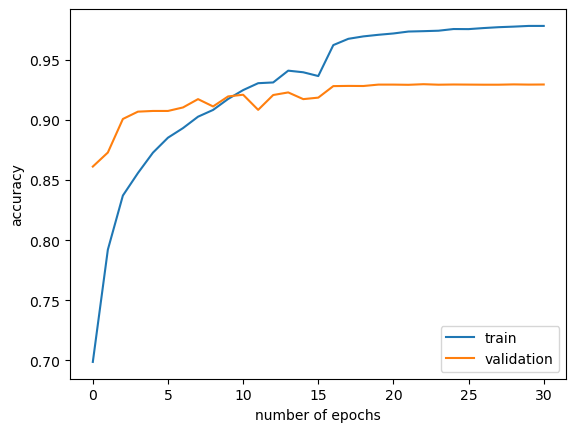

In [43]:
## plot validation accuracy vs train accuracy
modelAcc = history.history['accuracy']
valAcc = history.history['val_accuracy']

plt.figure()
plt.xlabel('number of epochs')
plt.ylabel('accuracy')
plt.plot(modelAcc, label='train')
plt.plot(valAcc, label='validation')
plt.legend(loc='lower right')
plt.show()

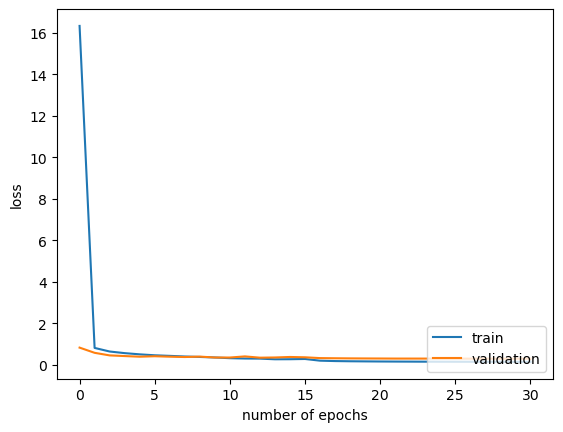

In [44]:
## plot validation loss vs train loss
modelLoss = history.history['loss']
valLoss = history.history['val_loss']

plt.figure()
plt.xlabel('number of epochs')
plt.ylabel('loss')
plt.plot(modelLoss, label='train')
plt.plot(valLoss, label='validation')
plt.legend(loc='lower right')
plt.show()

313/313 [==============================] - 1s 3ms/step


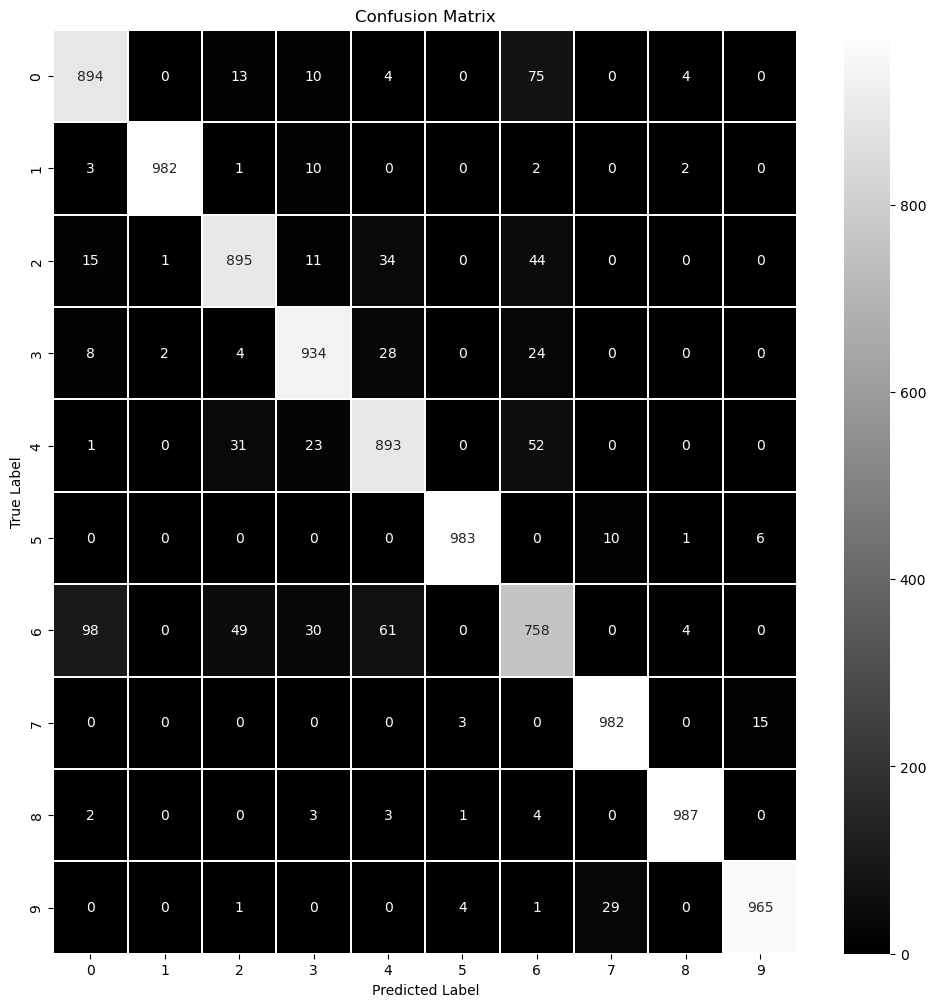

In [40]:
## visualise the results
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis = 1)
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 

f,ax = plt.subplots(figsize = (12,12))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.1, cmap="gist_gray", linecolor="white", fmt='.0f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
tuner.results_summary()

## REFERENCES
### ‎
##### https://keras.io/api/datasets/fashion_mnist/   (dataset)
##### https://medium.com/analytics-vidhya/classification-of-images-based-on-fashion-mnist-dataset-bb11e4bcdefb
##### https://datascience.stackexchange.com/questions/44124/when-to-use-dense-conv1-2d-dropout-flatten-and-all-the-other-layers
##### https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-fashion-mnist-clothing-classification/#:~:text=The%20Fashion%2DMNIST%20dataset%20is,shirts%2C%20dresses%2C%20and%20more.
##### https://medium.com/@mjbhobe/classifying-fashion-with-a-keras-cnn-achieving-94-accuracy-part-3-c7ca2919232b
##### https://www.kaggle.com/code/rutvikdeshpande/fashion-mnist-cnn-beginner-98/notebook
##### https://www.kaggle.com/code/jserna/hyperparameters-optimization-on-fashion-mnist
##### https://programming-review.com/machine-learning/overfitting
##### https://www.kaggle.com/code/cdeotte/how-to-choose-cnn-architecture-mnist/notebook
##### https://www.kaggle.com/code/cdeotte/25-million-images-0-99757-mnist/notebook
##### https://medium.com/analytics-vidhya/image-augmentation-using-keras-99072b490c72
##### https://github.com/Prachi-Gopalani13/Image-Augmentation-Using-Keras/blob/main/Image_Augmentation_using_Keras.ipynb
##### https://neptune.ai/blog/how-to-choose-a-learning-rate-scheduler
##### https://www.baeldung.com/cs/training-validation-loss-deep-learning
##### https://datascience.stackexchange.com/questions/65471/validation-loss-much-higher-than-training-loss
##### https://jinwen17.medium.com/tricks-to-prevent-overfitting-in-cnn-model-trained-on-a-small-dataset-b84f05eb4eb7
##### https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-keras.md
##### https://github.com/keras-team/keras/issues/3755
##### https://stats.stackexchange.com/questions/531075/why-validation-accuracy-is-increasing-very-slowly
##### https://becominghuman.ai/priming-neural-networks-with-an-appropriate-initializer-7b163990ead
##### https://machinelearningmastery.com/weight-initialization-for-deep-learning-neural-networks/
##### https://medium.com/@gidim/part-2-selecting-the-right-weight-initialization-for-your-deep-neural-network-cc27cf2d5e56
##### https://stackoverflow.com/questions/48137312/is-weight-initialization-different-for-dense-and-convolutional-layers
##### https://www.reddit.com/r/tensorflow/comments/gqqbyl/why_is_my_validation_accuracy_so_high/